**Objective**: Implement contrastive representation learning with SimCLR on small dataset using Tensorflow

Source: 
* https://github.com/sayakpaul/SimCLR-in-TensorFlow-2/blob/master/SimCLR_ImageNet_Subset.ipynb
* https://wandb.ai/sayakpaul/simclr/reports/Towards-Self-Supervised-Image-Understanding-with-SimCLR--VmlldzoxMDI5NDM

In [1]:
# Useful imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

import os
from PIL import Image

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [2]:
# Getting the dataset from the github repo of imagenet 5 categories
!git clone https://github.com/thunderInfy/imagenet-5-categories.git

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 22.44 MiB/s, done.
Resolving deltas: 100% (1/1), done.


# Image Dataset

In [21]:
# root folder is the name of the folder where data is contained
root_folder = 'imagenet-5-categories'

train_names = sorted(os.listdir(root_folder + '/train'))
test_names = sorted(os.listdir(root_folder + '/test'))

# Only keeping car, elephant, and airplane picture for a smaller dataset
train_images = []
for i, x in enumerate(train_names):
  if x.split('_')[0] not in ['dog', 'cat']:
    train_images.append(root_folder + '/train/' + train_names[i])
test_images = []
for i, x in enumerate(test_names):
  if x.split('_')[0] not in ['dog', 'cat']:
    test_images.append(root_folder + '/test/' + test_names[i])

# 10% of the train data use for linear classifier (to test check efffectiveness of SimCLR)
train_images_10 = np.random.choice(train_images, len(train_images)//10)

print("Number of train images:", len(train_images))
print("Number of test images:", len(test_images))
print("10% of training data with labels:", len(train_images_10))

Number of train images: 750
Number of test images: 150
10% of training data with labels: 75


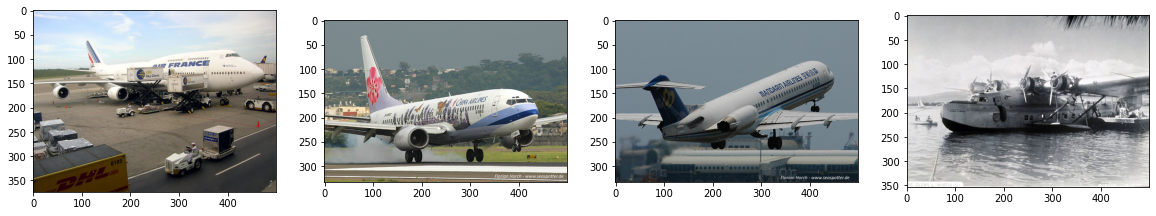

In [22]:
fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    image = Image.open(train_images[i])
    ax.imshow(image)

## Preprocessing

In [23]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])
    return image

In [24]:
# Create TensorFlow dataset
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Augmentation

In [25]:
# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)
        
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

# SimCLR Framework

## Contrastive Loss (NT-XEnt)
* Augmented image should have similar representations as original image
* Goal - Maximized the agreement (cosine similarity) between these image by minimizing the contrastive loss (Normalized Temperature-Scaled Cross-Entropy Loss) between the vectors 

In [26]:
def sim_func_dim1(x, y):
    # x shape: (N, 1, C), y shape: (N, C, 1), v shape: (N, 1, 1)
    v = tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(y, 2))
    return v

def sim_func_dim2(x, y):
    v = tf.tensordot(tf.expand_dims(x, 1), tf.expand_dims(tf.transpose(y), 0), axes=2)
    # x shape: (N, 1, C), y shape: (1, C, 2N), v shape: (N, 2N)
    return v

def get_negative_mask(batch_size):
    # return a mask that removes the similarity score of equal/similar images.
    # this function ensures that only distinct pair of images get their similarity scores
    # passed as negative examples
    negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0
    return tf.constant(negative_mask)

negative_mask = get_negative_mask(BATCH_SIZE)    

## ResNet50 Model

In [27]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

## Training Step

In [28]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [29]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

In [30]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.1, decay_steps=1000)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=50)

  2%|▏         | 1/50 [01:17<1:03:08, 77.31s/it]

epoch: 1 loss: 4.168


 22%|██▏       | 11/50 [06:57<23:18, 35.86s/it]

epoch: 11 loss: 3.465


 42%|████▏     | 21/50 [12:30<16:07, 33.35s/it]

epoch: 21 loss: 3.045


 62%|██████▏   | 31/50 [18:04<10:33, 33.32s/it]

epoch: 31 loss: 2.733


 82%|████████▏ | 41/50 [23:38<04:59, 33.31s/it]

epoch: 41 loss: 2.412


100%|██████████| 50/50 [28:36<00:00, 34.33s/it]


# Evaluation Comparison

In [31]:
def plot_training(H):
  plt.plot(H.history["loss"], label="train_loss")
  plt.plot(H.history["val_loss"], label="val_loss")
  plt.plot(H.history["accuracy"], label="train_acc")
  plt.plot(H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")
  plt.show()

## Linear Model

In [32]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## Image Preprocessing for Linear Classifier

In [33]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

100%|██████████| 75/75 [00:00<00:00, 180.88it/s]


(75, 224, 224, 3) (75,)


100%|██████████| 150/150 [00:00<00:00, 215.60it/s]


(150, 224, 224, 3) (150,)


## Training Model

### w/ Non-linear Projections

In [34]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0     

Epoch 1/35
2/2 [==============================] - 1s 182ms/step - loss: 4.8845 - accuracy: 0.2133 - val_loss: 4.6808 - val_accuracy: 0.1867
Epoch 2/35
2/2 [==============================] - 0s 29ms/step - loss: 4.4961 - accuracy: 0.2267 - val_loss: 4.3385 - val_accuracy: 0.1933
Epoch 3/35
2/2 [==============================] - 0s 26ms/step - loss: 4.1352 - accuracy: 0.2400 - val_loss: 4.0279 - val_accuracy: 0.2067
Epoch 4/35
2/2 [==============================] - 0s 26ms/step - loss: 3.8169 - accuracy: 0.2400 - val_loss: 3.7517 - val_accuracy: 0.2067
Epoch 5/35
2/2 [==============================] - 0s 26ms/step - loss: 3.5330 - accuracy: 0.2800 - val_loss: 3.5170 - val_accuracy: 0.2467
Epoch 6/35
2/2 [==============================] - 0s 27ms/step - loss: 3.2824 - accuracy: 0.2667 - val_loss: 3.3230 - val_accuracy: 0.2467
Epoch 7/35
2/2 [==============================] - 0s 27ms/step - loss: 3.0674 - accuracy: 0.2800 - val_loss: 3.1592 - val_accuracy: 0.2533
Epoch 8/35
2/2 [==========

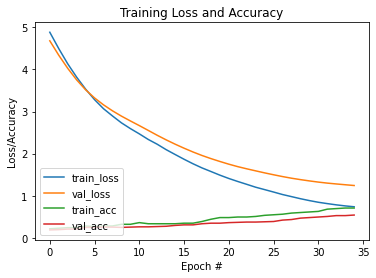

In [35]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

# Linear model
linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

### w/ No Projection

In [36]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(75, 2048) (150, 2048)


Epoch 1/35
2/2 [==============================] - 0s 163ms/step - loss: 2.2059 - accuracy: 0.2933 - val_loss: 2.4397 - val_accuracy: 0.3267
Epoch 2/35
2/2 [==============================] - 0s 27ms/step - loss: 2.2046 - accuracy: 0.4000 - val_loss: 1.6614 - val_accuracy: 0.4067
Epoch 3/35
2/2 [==============================] - 0s 28ms/step - loss: 1.5443 - accuracy: 0.4533 - val_loss: 1.0468 - val_accuracy: 0.4533
Epoch 4/35
2/2 [==============================] - 0s 29ms/step - loss: 0.9898 - accuracy: 0.4800 - val_loss: 1.3041 - val_accuracy: 0.4533
Epoch 5/35
2/2 [==============================] - 0s 27ms/step - loss: 1.0920 - accuracy: 0.5200 - val_loss: 1.0959 - val_accuracy: 0.5467
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


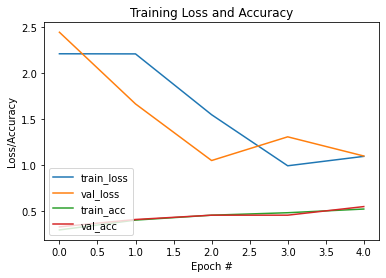

In [37]:
linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

# TSNE Visualization
Use t-SNE for plotting image cluster

In [41]:
# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 3))
    plt.show()
    return fig

## w/ Non-linear Projections

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


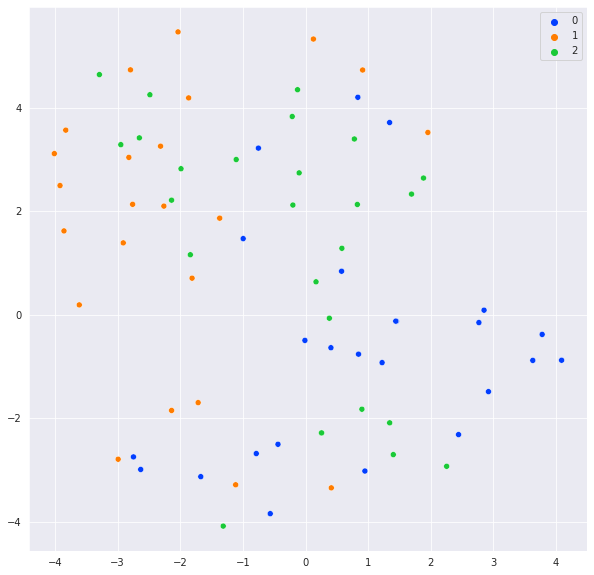

In [42]:
# Representations with second last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


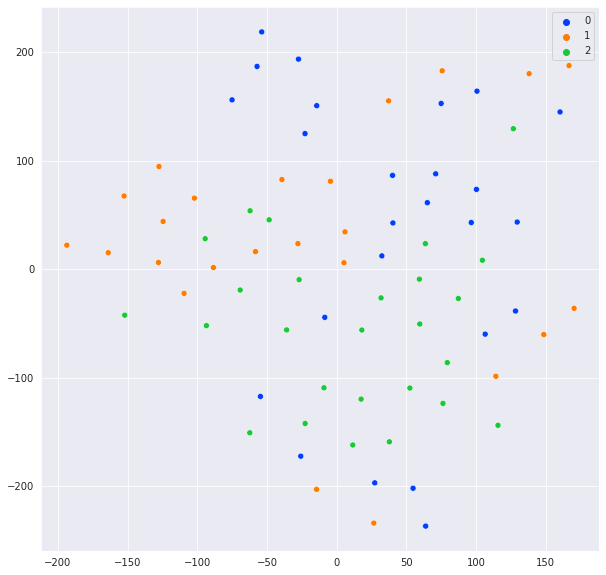

In [43]:
# Representations with the last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)

## w/ No Projection

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


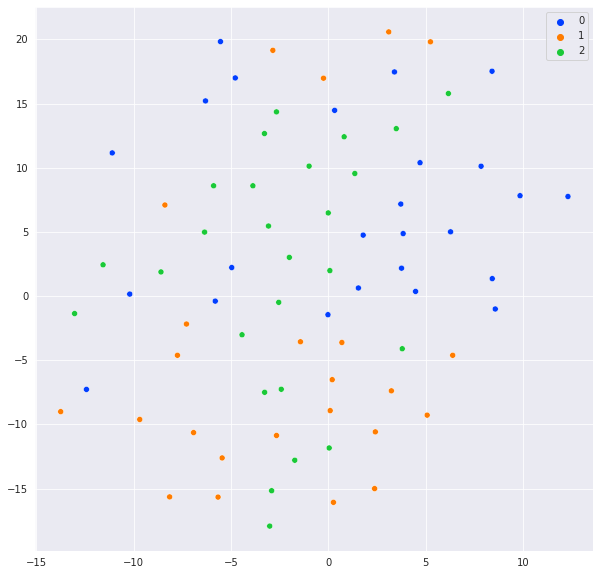

In [44]:
# Representations with no nonlinear projections
tsne = TSNE()
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)